# LiMnO DRX Cluster Expansion
This example shows a more in depth example of how to generate, fit and sample a cluster expansion for a slightly more complex scenario.

### 0) Load all data 
Load the structures with oxidation state assignments and prepare the target vector for learning. Target vector is usually a vector of total energies. 

In [1]:
# load the training structures with oxidation state assigned
from monty.serialization import loadfn

entries = loadfn("data/lmo_drx_entries.json")

### 1) Define a cluster expansion

#### Load and inspect the lattice primitive cell with multi-site disorder

In [2]:
prim = loadfn("data/lmo_drx_prim.json")

See that the primitive cell is randomly disordered. When occupancies on a site (#) do not add to 1, it means vacancies are considered.

In [3]:
import crystal_toolkit
print(prim)
prim

Full Formula (Li0.7 Mn1.1 O1)
Reduced Formula: Li0.7Mn1.1O1
abc   :   2.969850   2.969850   2.969850
angles:  60.000000  60.000000  60.000000
Overall Charge: +1.5
Sites (4)
  #  SP                                                a     b     c
---  ---------------------------------------------  ----  ----  ----
  0  Li+:0.250, Mn2+:0.250                          0.75  0.75  0.75
  1  Li+:0.250, Mn2+:0.250                          0.25  0.25  0.25
  2  Li+:0.200, Mn2+:0.200, Mn3+:0.200, Mn4+:0.200  0     0     0
  3  O2-                                            0.5   0.5   0.5


If you see this text, the Crystal Toolkit Jupyter Lab 

extension is not installed. You can install it by running 

"pip install crystaltoolkit-extension" 

from the same environment you run "jupyter lab". 

This only works in Jupyter Lab 3.x or above.


Structure Summary
Lattice
    abc : 2.96985 2.9698500000000005 2.96985
 angles : 60.00000000000001 59.99999999999999 60.00000000000001
 volume : 18.522028420882272
      A : 2.571965545429215 0.0 1.4849250000000003
      B : 0.8573218484764051 2.4248723708682074 1.4849250000000003
      C : 0.0 0.0 2.96985
Overall Charge: +1.5
PeriodicSite: Li+:0.250, Mn2+:0.250 (2.5720, 1.8187, 4.4548) [0.7500, 0.7500, 0.7500]
PeriodicSite: Li+:0.250, Mn2+:0.250 (0.8573, 0.6062, 1.4849) [0.2500, 0.2500, 0.2500]
PeriodicSite: Li+:0.200, Mn2+:0.200, Mn3+:0.200, Mn4+:0.200 (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: O2- (1.7146, 1.2124, 2.9699) [0.5000, 0.5000, 0.5000]

#### Specify cluster subspace information
We will include an electrostatic term in the subspace as well

In [4]:
from smol.cofe import ClusterSubspace
from smol.cofe.extern import EwaldTerm

CLUSTERCUTOFFS = {2: 6, 3: 4, 4:2}
LTOL, STOL, ATOL = 0.15, 0.20, 15
BASIS = 'sinusoid'

cs = ClusterSubspace.from_cutoffs(structure=prim,
                                  cutoffs = CLUSTERCUTOFFS,
                                  ltol = LTOL, 
                                  stol = STOL, 
                                  angle_tol = ATOL,
                                  supercell_size = ('O2-'),
                                  basis = BASIS, 
                                  orthonormal=False)
cs.add_external_term(EwaldTerm())

Print some information about the subspace, such as the number of correlation functions for the random structure $\langle \Phi_\beta \rangle$, number of function clusters $\alpha$, number of orbits $\textbf{B}$, and the orbit ids for all correlation functions $B$ which describes how correlation functions are grouped together. 

In [5]:
print(cs)

Basis/Orthogonal/Orthonormal : sinusoid/True/{self.basis_orthonormal}
       Unit Cell Composition : Li+0.7 Mn2+0.7 Mn3+0.2 Mn4+0.2 O2-1
            Number of Orbits : 40
No. of Correlation Functions : 386
             Cluster Cutoffs : 2: 5.94, 3: 3.64
              External Terms : [EwaldTerm(total)]
Orbit Summary
 ------------------------------------------------------------------------
 |  ID     Degree    Cluster Diameter    Multiplicity    No. Functions  |
 |   0       0             NA                 0                1        |
 |   1       1            0.0000              2                2        |
 |   2       1            0.0000              1                4        |
 |   3       2            1.8187              8                8        |
 |   4       2            2.1000              6                3        |
 |   5       2            2.9698              12               3        |
 |   6       2            2.9699              6               10        |
 |   7       2  

Load structure data into the StructureWrangler, which is used later for fitting

In [6]:
from smol.cofe import StructureWrangler

sw = StructureWrangler(cs)
for entry in entries:
    sw.add_entry(entry, verbose=False)

This next step may take a few minutes to complete. 

Our final feature matrix for fitting has shape $n \times p$ where $n$ is the number of structures and $p$ is the number of correlation functions for our training structure and the Ewald energy. 

In [7]:
print ('Our feature matrix has the following dimensions:', 
       sw.feature_matrix.shape)

Our feature matrix has the following dimensions: (238, 387)


### 2. Fit a cluster expansion

Here we are fitting $E(\sigma) = \sum_\beta m_\beta J_\beta \langle \Phi (\sigma)_\alpha \rangle_\beta + \frac{1}{\epsilon}E_{Ewald}(\sigma) $ and we will do with various compressive sensing techniques because the system is under-determined because $n$ < $p$. Our feature matrix $\textbf{X}$ is the matrix of all correlation functions and Ewald energy for our structures. We are interested in finding $ m_\beta J_\beta$ and $\frac{1}{\epsilon}$ which together form vector $\vec w$.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse 
import numpy as np
import copy

We will use L1-regularization, which is to minimize the following objective function with a penalty parameter $\lambda$ (note that in sklearn this is called $\alpha$, but we have already used this to define our function cluster). 
\begin{equation}
\frac{1}{2n}||E-\textbf{X}\vec w||_2^2 + \lambda ||\vec w||_1
\end{equation}

We will optimize the hyperparameter using only a single fit with a train/test split. However, improved results can be obtained from doing a proper cross validation optimization.

In [9]:
import warnings
from sklearn.linear_model import Lasso
from sklearn.exceptions import ConvergenceWarning

TRIALS = 50
TEST_SIZE = 0.20
PROPERTY = 'energy'

# we will suppress convergence warnings for now
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    all_rmse = [] 
    for alpha in np.logspace(-5, -3):
        rmse_list = [] 
        for _ in range(TRIALS):
            X_train, X_test, y_train, y_test = train_test_split(
                sw.feature_matrix, sw.get_property_vector(key=PROPERTY),
                test_size=TEST_SIZE
            )
            model = Lasso(alpha=alpha, fit_intercept=True)
            # remove the constant correlation since we are fitting
            # the intercept
            model.fit(X_train[:, 1:], y_train)
            wvec = np.concatenate((np.array([model.intercept_]), 
                                   model.coef_),
                                  axis=0)
            y_predict = np.dot(X_test, wvec)
            rmse = np.sqrt(mse(y_test, y_predict))
            rmse_list.append(rmse)
        all_rmse.append(np.mean(rmse_list))

Load plotting tools to examine how the fitting is going.

Text(0, 0.5, 'Average RMSE (eV/prim) in 50 trials')

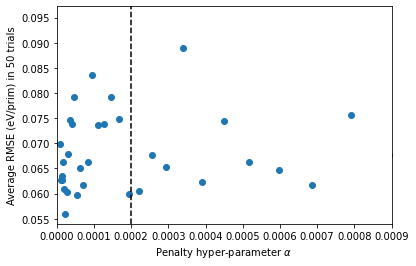

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(np.logspace(-5,-2), all_rmse)
plt.xlim([0, 0.0009])
plt.axvline(x = 0.0002, ls = '--', color = 'black')
plt.xlabel(r'Penalty hyper-parameter $\alpha$')
plt.ylabel('Average RMSE (eV/prim) in 50 trials')

Although we sampled a large space of penalties, $10^{-5}$ to $10^{-2}$, it turns out that the relevant space of hyperparameters is $10^{-5}$ to $10^{-4}$. 

We choose the penalty of $\lambda=0.0002$ as the regularization parameter. So, we settle on our final model and show the out-of-sample and in-sample RMSE.

The weights $\vec w$ are also plotted.

Out-of-sample RMSE is: 0.1542109191827612 eV/prim
In-sample RMSE is: 0.02426213156609966 eV/prim
Number of Features > 1E-5: 41/387
Point correlation coefficients: [-20.88771952  -2.04993158   0.           0.           1.18082107
  -1.78346928   0.        ]


/home/lbluque/miniconda3/envs/matx_dev/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16306747608609712, tolerance: 0.05853817658209538
  model = cd_fast.enet_coordinate_descent(


Text(0, 0.5, 'Magnitude |$w_i$| eV/prim')

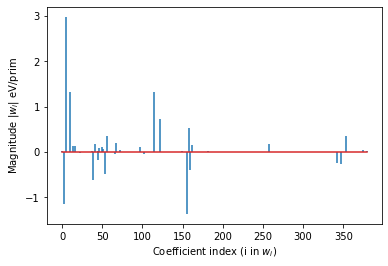

In [12]:
LAMBDA = 0.0002
X_train, X_test, y_train, y_test = train_test_split(
    sw.feature_matrix, sw.get_property_vector(key=PROPERTY),
    test_size=TEST_SIZE
)

model = Lasso(alpha=LAMBDA, fit_intercept=True)
model.fit(X_train[:, 1:], y_train)

wvec = np.concatenate(
    (np.array([model.intercept_]), model.coef_),
    axis=0
)

y_predict = np.dot(X_test, wvec)
y_train_predict = np.dot(X_train, wvec)
print(f'Out-of-sample RMSE is: {np.sqrt(mse(y_test, y_predict))} eV/prim')
print(f'In-sample RMSE is: {np.sqrt(mse(y_train, y_train_predict))} eV/prim')
print(f'Number of Features > 1E-5: {sum(np.abs(wvec) > 1E-5)}/{len(wvec)}')

first_pair = cs.orbits_by_size[2][0].bit_id
print(f'Point correlation coefficients: {wvec[:first_pair]}')
# plot the coefficients (excluding those for points))
plt.stem(range(len(wvec) - first_pair), wvec[first_pair:],
         linefmt='-', markerfmt=' ')#, basefmt=' ')
plt.xlabel('Coefficient index (i in $w_i$)')
plt.ylabel('Magnitude |$w_i$| eV/prim')

#### Generate the Cluster Expansion object

In [13]:
from smol.cofe import RegressionData, ClusterExpansion
from random import choice

reg_data = RegressionData.from_sklearn(
    model, sw.feature_matrix, sw.get_property_vector(key=PROPERTY)
)

expansion = ClusterExpansion(
    cs, coefficients=wvec, regression_data=reg_data
)


structure = choice(sw.structures)
prediction = expansion.predict(structure, normalize=True)
print(f"Structure with composition {structure.composition} has predicted energy {prediction} eV/prim")

Structure with composition Li+10 Mn4+12 Mn3+2 O2-32 has predicted energy -18.959213889450854 eV/prim


### 3) Run Canonical Monte Carlo

Now let's run a canonical MC disordering of spinel LiMn2O4. 

#### First load the spinel structure

In [14]:
# load the spinel structure first and determine its supercell matrix

spinel = loadfn('data/LiMn2O4_drx_tutorial.json')
starting_matrix = sw.cluster_subspace.scmatrix_from_structure(spinel)

#### Generate an ensemble for a given transformation of the starting spinel structure and convert the spinel structure into an initial occupancy 

In [15]:
from smol.moca import Ensemble
from smol.moca import Sampler

transformation = np.matrix([[3, 0, 0], [0, 3, 0], [0, 0, 3]])

sc_matrix = starting_matrix @ transformation

# Create an Ensemble as
ensemble = Ensemble.from_cluster_expansion(expansion, sc_matrix)
# Since computing the Ewald matrix is very time consuming make sure to
# save/load the ensemble or processor
# ensemble = dumpfn(ensemble, "data/lmo_drx_ensemble.json")

spinel = spinel.__mul__(transformation)
init_occu = ensemble.processor.occupancy_from_structure(spinel)

#### Generate sampler for canonical MC disordering from $T_0 = 300 K$ to $T_f = 500 K$ in steps of $50  K$ as a mini simulation
Computing the ewald matrix necessary for fast MC evaluation for large supercells with multi-component structures such as this example can take a long time.
Since this is done lazily in the code it will seem like the first step of MC is unbearibly long. It is suggested to save the ensemble or processor used such that the Ewald matrix does not need to be reconstructed at runtime.

In [16]:
from smol.moca import Sampler

T0 = 300 
TF = 500 
STEP = 50
PROPOSALS = int(1E5)
current_occu = None
save_data = {}

for T in range(T0, TF + 1, STEP): 
    sampler = Sampler.from_ensemble(ensemble=ensemble, 
                                    kernel_type='Metropolis',
                                    temperature=T)
    if current_occu is None: 
        current_occu = init_occu

    sampler.run(PROPOSALS,
                initial_occupancies=current_occu,
                thin_by=100, 
                progress=True)
    current_occu = sampler.samples.get_occupancies()[-1]
    
    # now save some data such as occupancies
    save_data[int(T)] = {'occupancies': sampler.samples.get_occupancies(),
                         'energies_total': sampler.samples.get_energies(), 
                         'features_unnormalized': sampler.samples.get_feature_vectors()}

Sampling 1 chain(s) from a cell with 3456 sites...: 100%|██████████| 100000/100000 [00:53<00:00, 1873.63it/s]
Sampling 1 chain(s) from a cell with 3456 sites...: 100%|██████████| 100000/100000 [00:51<00:00, 1947.93it/s]
Sampling 1 chain(s) from a cell with 3456 sites...: 100%|██████████| 100000/100000 [00:51<00:00, 1950.93it/s]
Sampling 1 chain(s) from a cell with 3456 sites...: 100%|██████████| 100000/100000 [00:51<00:00, 1955.61it/s]
Sampling 1 chain(s) from a cell with 3456 sites...: 100%|██████████| 100000/100000 [00:51<00:00, 1956.76it/s]


#### Now save the data

In [ ]:
from monty.serialization import dumpfn

filename = "canonical_MC_LiMn2O4_{}_{}_{}.json".format(T0, TF, STEP)
dumpfn(save_data, filename)